##### Initialization

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import time
import pickle

In [2]:
# ### Ignore this if this file isn't being run on a Colab Notebook

# def mount_drive_select_path(drive_path = "/content/drive/MyDrive/UA/5º Ano/Tese"):

#   # Mount drive
#   from google.colab import drive
#   drive.mount('/content/drive', force_remount = True)

#   # Drive path
#   %cd $drive_path

# path = "/content/drive/MyDrive/UA/5º Ano/Tese/Professora\ - Dados\ -\ LSTMs"
# mount_drive_select_path(drive_path = path)

# Notebook

The folder time_series contains a list of files. Each file contains all the time series associated with a given product. Each time series corresponds to a company.

There are two types of files:

**- Wide**: each column corresponds to the time series of a company.

**- Long**: the information is stored in long format. The column company identifies the company, the colum timestamp the instant at which a price was recorded, and the column price the value of the price. These dataframes contain some other columns whose meaning will be explained next.

On the title of each file the Product Group (a product group corresponds to a group of time series of the same product sold by different companies) is identified by a number, called the product_group_id.

The file 'product_information' contains information about the products in each product group. This file contains the following columns:

- **offer_type** - offer type associated with that time series. A product can be locked, unlocked... to a certain operator.
- **product** - name of the product associated with time series
- **product_group_id** - uniquely identifies a product group. A product group is uniquely identified by its name and its offer_type.

**Example**: read a file and its product_information

In [3]:
# Select product_group_id
product_group_id = 958

In [4]:
# Read file
df_1 = pd.read_pickle("Data/time_series_1/wide_product_group_id_" + str(product_group_id))
df_1

,Abcdin,Falabella,Lider,Paris,Ripley,claro,entel,movistar,wom,vtr,macOnline
2020-06-21,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627,NaN,NaN
2020-06-22,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627,NaN,NaN
2020-06-23,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627,NaN,NaN
2020-06-24,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627,NaN,NaN
2020-06-25,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-05,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN,NaN,NaN
2021-11-06,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN,NaN,NaN
2021-11-07,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN,NaN,NaN
2021-11-08,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN,NaN,NaN


In [5]:
# Read product information of the time series of that product group
product_information = pd.read_pickle("Data/product_information")
product_information.loc[product_group_id]

product       huawei Y9S 128GB
offer_type            unlocked
Name: 958, dtype: object

In [6]:
product_information

,product,offer_type
product_group_id,,
1,xiaomi Pocophone 128GB,unlocked
2,xiaomi Redmi Note 8 128GB,unlocked
5,xiaomi Redmi Note 9 Pro 64GB + AIWA AW 6,unlocked
6,xiaomi Redmi Note 9 Pro 64GB + AIWA AW 8,unlocked
7,blu Joy Adulto Mayor Sos,unlocked
...,...,...
952,huawei P30 128GB + P Smart 2019,unlocked
953,motorola Moto G7 Power 64GB,unlocked
956,nokia 6.1 32GB,unlocked


**Example**: convert a long dataframe to a wide format

In [7]:
df_long = pd.read_pickle("Data/time_series_1/long_product_group_id_" + str(product_group_id))
df_wide = df_long.reset_index().groupby(['timestamp', "company"])["price"].first().unstack().reset_index().set_index("timestamp")

# Fill missing timestamps
timestamps  = pd.DataFrame(index = pd.date_range(df_wide.index[0],df_wide.index[-1], freq='D'))
df_wide = pd.merge(timestamps, df_wide, left_index = True, right_index = True, how = 'left')
df_wide.columns.name = None

In [8]:
df_long

,product_id,timestamp,product,country,company,product_group_id,offer_type,price
422267,3217,2020-06-21,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422268,3217,2020-06-22,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422269,3217,2020-06-23,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422270,3217,2020-06-24,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422271,3217,2020-06-25,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
...,...,...,...,...,...,...,...,...
426112,3230,2021-03-18,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426113,3230,2021-03-19,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426114,3230,2021-03-20,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426115,3230,2021-03-21,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955


In [9]:
df_wide

,Abcdin,Falabella,Lider,Paris,Ripley,claro,entel,movistar,wom
2020-06-21,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
2020-06-22,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
2020-06-23,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
2020-06-24,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
2020-06-25,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
...,...,...,...,...,...,...,...,...,...
2021-11-05,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN
2021-11-06,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN
2021-11-07,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN
2021-11-08,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN


In [10]:
# fix random seed for reproducibility
np.random.seed(7)

from sklearn.preprocessing import MinMaxScaler


def get_product_wide(product_group_id, time_series='2'):
    df_long = pd.read_pickle(f"Data/time_series_{time_series}/long_product_group_id_{product_group_id}")
    df_wide = df_long.reset_index().groupby(['timestamp', "company"])["price"].first().unstack().reset_index().set_index("timestamp")
    # Fill missing timestamps
    timestamps  = pd.DataFrame(index = pd.date_range(df_wide.index[0],df_wide.index[-1], freq='D'))
    df_wide = pd.merge(timestamps, df_wide, left_index = True, right_index = True, how = 'left')
    df_wide.columns.name = None
    
    
    return df_wide

In [11]:
get_product_wide(789, time_series='2').keys()

Index(['claro', 'movistar'], dtype='object')

# Univariate LSTM

<AxesSubplot:>

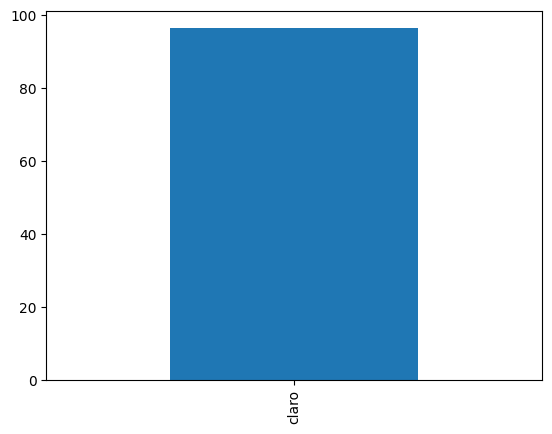

In [13]:
df_wide.mean().plot(kind='bar')

## Data Visualization

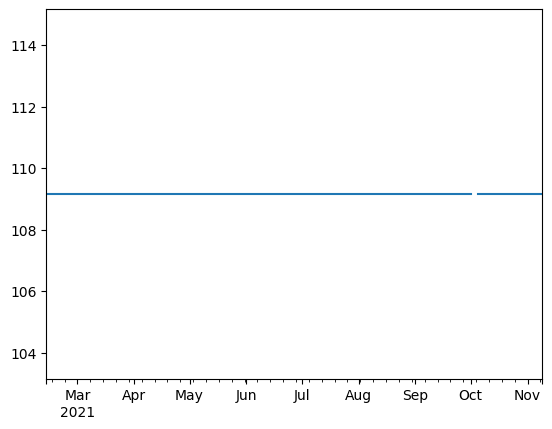

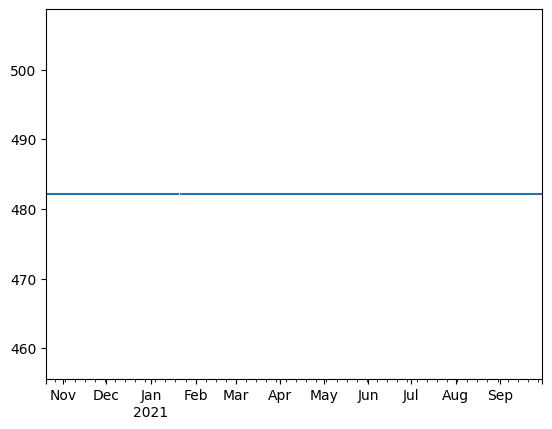

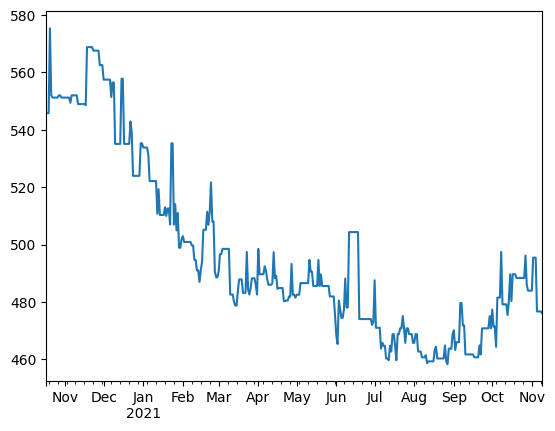

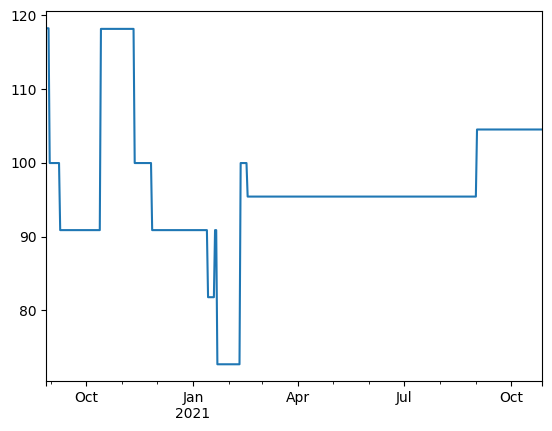

In [12]:
import glob

time_series = '2'

for i, file in enumerate(glob.glob(f"Data/time_series_{time_series}/*")):
    product_group_id = file.split("_")[-1]
    df_wide = get_product_wide(product_group_id, time_series)
    
    df_wide.mean(axis=1).plot()
    plt.show()
    if i == 3:
        break

In [106]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


company = "movistar"
n_steps = 7 # number of days
train_split_amount = 0.7

X_train = np.empty(shape=[0, n_steps], dtype=np.float32)
y_train = np.array([], dtype=np.float32)
X_test = np.empty(shape=[0, n_steps], dtype=np.float32)
y_test = np.array([], dtype=np.float32)

for i, file in enumerate(glob.glob(f"Data/time_series_{time_series}/*")):
    product_group_id = file.split("_")[-1]
    df_wide = get_product_wide(product_group_id, time_series)
    if company in df_wide.keys():
        # DROP NAN VALUES
        prices = df_wide[company].dropna().values

        # SPLIT THE TIME SERIES OF PRICES INTO SEVERAL SHORT SEQUENCES
        X, y = split_sequence(prices, n_steps)
        
        # split into train and test sets
        train_size = int(len(y) * train_split_amount)
        test_size = len(y) - train_size
        
        # ADD DATA TO DATASET
        X_train = np.concatenate((X_train, X[0:train_size,:]))
        y_train = np.append(y_train, y[0:train_size])
        X_test = np.concatenate((X_test, X[train_size:,:]))
        y_test = np.append(y_test, y[train_size:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(19758, 7)
(19758,)
(8516, 7)
(8516,)
